In [36]:
import numpy as np 
import pandas as pd 

df_train = pd.read_csv('train.csv')
df_test =pd.read_csv('test.csv')
df_sample= pd.read_csv('sample_submission.csv')
df_orig=pd.read_csv("kindey stone urine analysis.csv")

In [37]:

df_train["is_generated"] = 1
df_test["is_generated"] = 1
df_orig["is_generated"] = 0
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            414 non-null    int64  
 1   gravity       414 non-null    float64
 2   ph            414 non-null    float64
 3   osmo          414 non-null    int64  
 4   cond          414 non-null    float64
 5   urea          414 non-null    int64  
 6   calc          414 non-null    float64
 7   target        414 non-null    int64  
 8   is_generated  414 non-null    int64  
dtypes: float64(4), int64(5)
memory usage: 29.2 KB


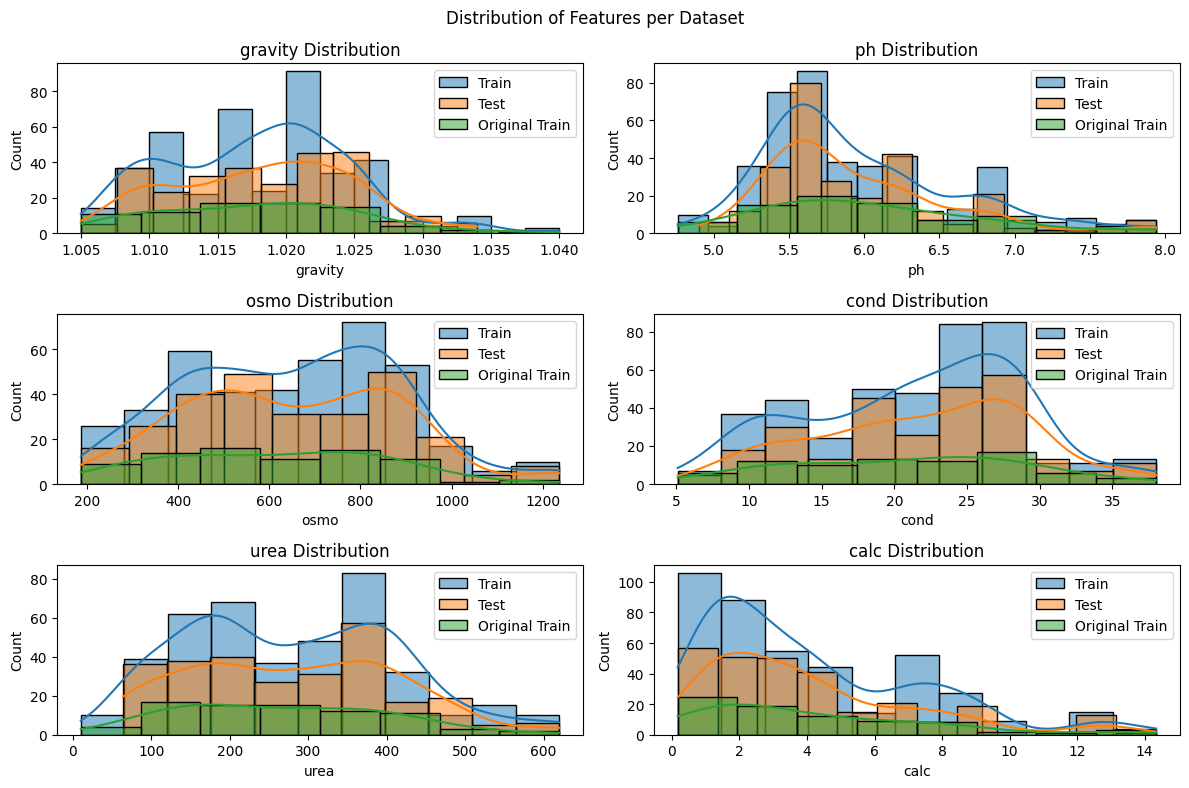

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

columns = [col for col in df_train.columns if df_train[col].nunique() > 10 and col != 'id']
fig, axes = plt.subplots(3, 2, figsize=(12, 8))
axes = axes.flatten()

for i, col in enumerate(columns):
    sns.histplot(x=df_train[col], data=df_train, ax=axes[i], kde=True, label='Train')
    sns.histplot(x=df_test[col], data=df_test, ax=axes[i], kde=True, label='Test')
    sns.histplot(x=df_orig[col], data=df_orig, ax=axes[i], kde=True, label='Original Train')

    axes[i].set_title(f'{col} Distribution')
    axes[i].set_xlabel(f'{col}')
    axes[i].legend(loc='upper right')

fig.suptitle('Distribution of Features per Dataset')
plt.tight_layout()
plt.show()

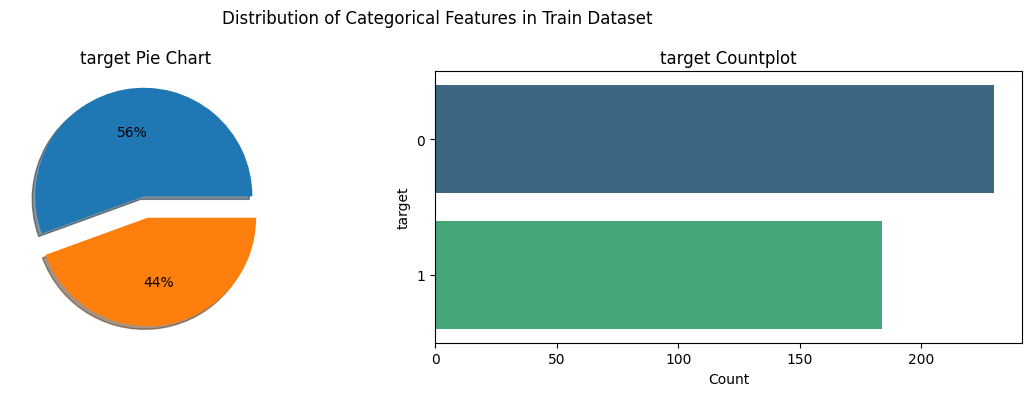

In [18]:
obj = [col for col in df_train.columns if df_train[col].nunique() < 10 and col not in ['id', 'is_generated']]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, column in enumerate(obj):
    ax = axes[0]
    ax.pie(
        df_train[column].value_counts(),
        shadow=True,
        explode=[0.1 for _ in range(df_train[column].nunique())],
        autopct='%1.f%%'
    )
    ax.set_aspect('equal')
    ax.set_title(f'{column} Pie Chart')

    ax1 = axes[1]
    sns.countplot(y=column, ax=ax1, palette='viridis', order=df_train[column].value_counts().index, data=df_train)
    ax1.set_xlabel('Count')
    ax1.set_ylabel(column)
    ax1.set_title(f'{column} Countplot')

fig.suptitle('Distribution of Categorical Features in Train Dataset')
plt.tight_layout()
plt.show()

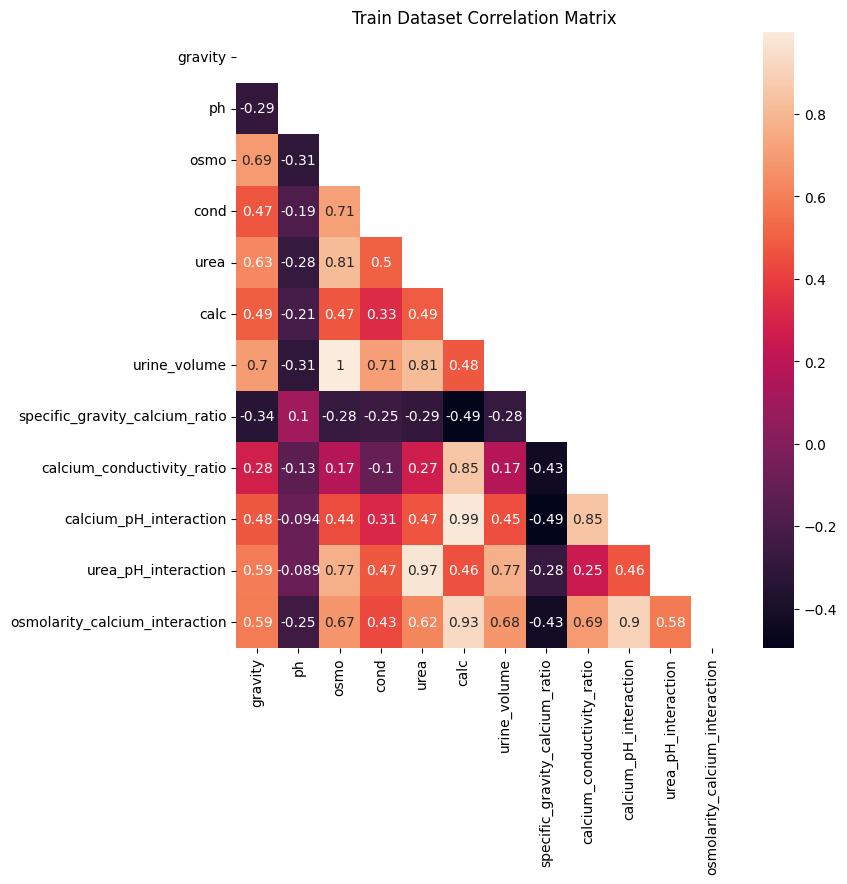

In [35]:
columns = [col for col in df_train.columns if df_train[col].nunique() > 10 and col not in ['id'] and df_train[col].dtype in ['int64', 'float64']]

corr = df_train[columns].corr()
plt.figure(figsize=(8, 8))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, annot=True)
plt.title('Train Dataset Correlation Matrix')
plt.show()

# feature engineering

In [54]:

def fe(df):
  df['urine_volume'] = (1000 * df['gravity'] * df['osmo']) / (18 * 1.001)
  df['specific_gravity_calcium_ratio'] = df['gravity'] / df['calc']
  df['calcium_conductivity_ratio'] = df['calc'] / df['cond']
  df['calcium_pH_interaction'] = df['calc'] * df['ph']
  df['urea_pH_interaction'] = df['urea'] * df['ph']
  df['osmolarity_calcium_interaction'] = df['osmo'] * df['calc']
  return df

dfs = [df_train, df_test, df_orig]
for df in dfs:
  fe(df)

In [55]:
features = [col for col in df_train.columns if col not in ['id', 'target', 'is_generated']]
target = 'target'


In [56]:
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

X = df_train[features]
y = df_train[target]

def crossval(model_name, model, n_folds, random_state, include_orig):
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    scores = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        if include_orig:
            X_train = pd.concat([X_train, df_orig[features]], ignore_index=True)
            y_train = pd.concat([y_train, df_orig[target]], ignore_index=True)

        if model_name == 'lgbm':
          callbacks = [lgb.callback.log_evaluation(period=0)]
          model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='auc', callbacks=callbacks)
        elif model_name == 'xgb':
          model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
        elif model_name == 'cat':
          model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

        y_test_pred = model.predict(X_test)

        score = roc_auc_score(y_test, y_test_pred)
        print(f"Fold {fold + 1}: AUC-ROC Score: {score}")
        scores.append(score)

    avg_score = sum(scores) / len(scores)
    print(f"Average score: {avg_score}")
    return scores

In [57]:
import optuna

# Define the objective function for LightGBM parameter optimization
def objective_lgbm(trial):
    # Parameters to be optimized
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 5e-1),
        'random_state': 42,
        'verbosity': -1
    }

    # Create a LightGBM classifier model with the suggested parameters
    model = lgb.LGBMClassifier(**params)

    # Perform cross-validation using the defined model
    scores = crossval(model_name='lgbm', model=model, n_folds=5, random_state=42, include_orig=True)

    # Return the mean of the cross-validation scores as the objective to be maximized
    return np.mean(scores)

# Create an Optuna study for optimization, aiming to maximize the objective function
study = optuna.create_study(direction='maximize')

# Optimize the learning rate using the defined objective function
study.optimize(objective_lgbm, n_trials=5)

# Retrieve the best learning rate found during the optimization
best_learning_rate = study.best_params['learning_rate']


[I 2024-01-01 01:37:39,425] A new study created in memory with name: no-name-6e4cf633-75b4-41de-93bc-f9c9a5f70973
[I 2024-01-01 01:37:39,554] Trial 0 finished with value: 0.7217946207076642 and parameters: {'learning_rate': 0.4102688133217207}. Best is trial 0 with value: 0.7217946207076642.


Fold 1: AUC-ROC Score: 0.6289659224441834
Fold 2: AUC-ROC Score: 0.7643948296122208
Fold 3: AUC-ROC Score: 0.7209165687426556
Fold 4: AUC-ROC Score: 0.7779083431257344
Fold 5: AUC-ROC Score: 0.7167874396135265
Average score: 0.7217946207076642
Fold 1: AUC-ROC Score: 0.6289659224441834
Fold 2: AUC-ROC Score: 0.737367802585194
Fold 3: AUC-ROC Score: 0.723560517038778
Fold 4: AUC-ROC Score: 0.7129847238542891


[I 2024-01-01 01:37:39,681] Trial 1 finished with value: 0.7023632327980154 and parameters: {'learning_rate': 0.49942205903771286}. Best is trial 0 with value: 0.7217946207076642.
[I 2024-01-01 01:37:39,825] Trial 2 finished with value: 0.7316229272751011 and parameters: {'learning_rate': 0.15541804522411237}. Best is trial 2 with value: 0.7316229272751011.


Fold 5: AUC-ROC Score: 0.7089371980676329
Average score: 0.7023632327980154
Fold 1: AUC-ROC Score: 0.6424794359576969
Fold 2: AUC-ROC Score: 0.7887779083431258
Fold 3: AUC-ROC Score: 0.7452996474735606
Fold 4: AUC-ROC Score: 0.7508813160987075
Fold 5: AUC-ROC Score: 0.7306763285024154
Average score: 0.7316229272751011
Fold 1: AUC-ROC Score: 0.6236780258519389
Fold 2: AUC-ROC Score: 0.7696827262044654


[I 2024-01-01 01:37:39,976] Trial 3 finished with value: 0.7190168429298864 and parameters: {'learning_rate': 0.39523139600714013}. Best is trial 2 with value: 0.7316229272751011.


Fold 3: AUC-ROC Score: 0.7452996474735606
Fold 4: AUC-ROC Score: 0.7643948296122208
Fold 5: AUC-ROC Score: 0.6920289855072463
Average score: 0.7190168429298864
Fold 1: AUC-ROC Score: 0.618096357226792
Fold 2: AUC-ROC Score: 0.7643948296122208
Fold 3: AUC-ROC Score: 0.731786133960047
Fold 4: AUC-ROC Score: 0.737367802585194


[I 2024-01-01 01:37:40,123] Trial 4 finished with value: 0.7093386865125995 and parameters: {'learning_rate': 0.29596058277994947}. Best is trial 2 with value: 0.7316229272751011.


Fold 5: AUC-ROC Score: 0.6950483091787439
Average score: 0.7093386865125995


# lgbm

In [58]:
def objective_lgbm_params(trial):
    # Define the LightGBM parameters to be optimized
    lgbm_params = {
        'max_depth': trial.suggest_int('max_depth', 1, 15),
        'metric': 'auc',
        'learning_rate': best_learning_rate,  # The best_learning_rate is not defined here, causing an issue
        'n_estimators': trial.suggest_int('n_estimators', 100, 5000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'verbosity': -1
    }

    # Create a LightGBM classifier model with the suggested parameters
    model = lgb.LGBMClassifier(**lgbm_params)

    # Perform cross-validation using the defined model
    scores = crossval(model_name='lgbm', model=model, n_folds=5, random_state=42, include_orig=True)

    # Return the mean of the cross-validation scores as the objective to be maximized
    return np.mean(scores)

# Create an Optuna study for optimization, aiming to maximize the objective function
study = optuna.create_study(direction='maximize')

# Optimize the LightGBM parameters using the defined objective function
study.optimize(objective_lgbm_params, n_trials=5)

# Retrieve the best parameters found during the optimization
best_params = study.best_params


[I 2024-01-01 01:37:41,328] A new study created in memory with name: no-name-09d34f63-0961-4bae-89b4-27007f7cc3c6


Fold 1: AUC-ROC Score: 0.6451233842538191
Fold 2: AUC-ROC Score: 0.7914218566392479
Fold 3: AUC-ROC Score: 0.723560517038778


[I 2024-01-01 01:37:41,838] Trial 0 finished with value: 0.7332843713278496 and parameters: {'max_depth': 1, 'n_estimators': 1714, 'min_child_weight': 3, 'colsample_bytree': 0.9363651889080187, 'reg_alpha': 0.8097191141397188, 'reg_lambda': 0.3241000163928914, 'subsample': 0.9421099163992077}. Best is trial 0 with value: 0.7332843713278496.


Fold 4: AUC-ROC Score: 0.7508813160987075
Fold 5: AUC-ROC Score: 0.7554347826086957
Average score: 0.7332843713278496
Fold 1: AUC-ROC Score: 0.6424794359576969
Fold 2: AUC-ROC Score: 0.7129847238542891
Fold 3: AUC-ROC Score: 0.7074030552291422
Fold 4: AUC-ROC Score: 0.8022914218566393


[I 2024-01-01 01:37:43,147] Trial 1 finished with value: 0.7268964616790703 and parameters: {'max_depth': 7, 'n_estimators': 2841, 'min_child_weight': 9, 'colsample_bytree': 0.8326179918548431, 'reg_alpha': 0.1923934710657181, 'reg_lambda': 0.0176457338557855, 'subsample': 0.7195517447537312}. Best is trial 0 with value: 0.7332843713278496.


Fold 5: AUC-ROC Score: 0.7693236714975845
Average score: 0.7268964616790703
Fold 1: AUC-ROC Score: 0.6559929494712105
Fold 2: AUC-ROC Score: 0.7264982373678026
Fold 3: AUC-ROC Score: 0.7074030552291422
Fold 4: AUC-ROC Score: 0.7726204465334899
Fold 5: AUC-ROC Score: 0.7584541062801932
Average score: 0.7241937589763676


[I 2024-01-01 01:37:44,037] Trial 2 finished with value: 0.7241937589763676 and parameters: {'max_depth': 9, 'n_estimators': 2491, 'min_child_weight': 19, 'colsample_bytree': 0.6014758079341052, 'reg_alpha': 0.6753586757752141, 'reg_lambda': 0.004098459688947732, 'subsample': 0.7475889876149989}. Best is trial 0 with value: 0.7332843713278496.


Fold 1: AUC-ROC Score: 0.6533490011750881
Fold 2: AUC-ROC Score: 0.737367802585194
Fold 3: AUC-ROC Score: 0.7426556991774383


[I 2024-01-01 01:37:44,491] Trial 3 finished with value: 0.7312442877660269 and parameters: {'max_depth': 3, 'n_estimators': 1063, 'min_child_weight': 11, 'colsample_bytree': 0.7003875034221065, 'reg_alpha': 0.08709039392325335, 'reg_lambda': 0.6592241474996565, 'subsample': 0.8815240630398197}. Best is trial 0 with value: 0.7332843713278496.


Fold 4: AUC-ROC Score: 0.7643948296122208
Fold 5: AUC-ROC Score: 0.7584541062801932
Average score: 0.7312442877660269
Fold 1: AUC-ROC Score: 0.618096357226792
Fold 2: AUC-ROC Score: 0.7291421856639247
Fold 3: AUC-ROC Score: 0.7074030552291422
Fold 4: AUC-ROC Score: 0.7861339600470034


[I 2024-01-01 01:37:45,698] Trial 4 finished with value: 0.7192420681551115 and parameters: {'max_depth': 15, 'n_estimators': 2961, 'min_child_weight': 19, 'colsample_bytree': 0.4101826311530216, 'reg_alpha': 0.3779770040228225, 'reg_lambda': 0.17098939155811466, 'subsample': 0.8601839075968682}. Best is trial 0 with value: 0.7332843713278496.


Fold 5: AUC-ROC Score: 0.7554347826086957
Average score: 0.7192420681551115


In [59]:
# Define the final LightGBM parameters based on the best parameters obtained from optimization
final_lgbm_params = {
    'max_depth': best_params['max_depth'],
    'metric': 'auc',
    'learning_rate': best_learning_rate,
    'n_estimators': best_params['n_estimators'],
    'min_child_weight': best_params['min_child_weight'],
    'colsample_bytree': best_params['colsample_bytree'],
    'reg_alpha': best_params['reg_alpha'],
    'reg_lambda': best_params['reg_lambda'],
    'subsample': best_params['subsample'],
    'verbosity': -1
}

# Create a LightGBM classifier with the final set of parameters
final_model = lgb.LGBMClassifier(**final_lgbm_params)

# Perform cross-validation using the final model
scores = crossval(model_name='lgbm', model=final_model, n_folds=5, random_state=42, include_orig=True)

# Calculate and print the mean of the cross-validation scores
mean_crossval_score = np.mean(scores)
print("Mean Cross-Validation Score:", mean_crossval_score)


Fold 1: AUC-ROC Score: 0.6451233842538191
Fold 2: AUC-ROC Score: 0.7914218566392479
Fold 3: AUC-ROC Score: 0.723560517038778
Fold 4: AUC-ROC Score: 0.7508813160987075
Fold 5: AUC-ROC Score: 0.7554347826086957
Average score: 0.7332843713278496
Mean Cross-Validation Score: 0.7332843713278496


In [60]:
import optuna

# Define the objective function for CatBoost parameter optimization
def objective_cat(trial):
    # Parameters to be optimized
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 5e-1),
        'random_state': 42
    }

    # Create a CatBoost classifier model with the suggested parameters
    model = cb.CatBoostClassifier(**params)

    # Perform cross-validation using the defined CatBoost model
    scores = crossval(model_name='cat', model=model, n_folds=5, random_state=42, include_orig=True)

    # Return the mean of the cross-validation scores as the objective to be maximized
    return np.mean(scores)

# Create an Optuna study for optimization, aiming to maximize the objective function
study = optuna.create_study(direction='maximize')

# Optimize the learning rate for CatBoost using the defined objective function
study.optimize(objective_cat, n_trials=5)

# Retrieve the best learning rate found during the optimization
best_learning_rate1 = study.best_params['learning_rate']


[I 2024-01-01 01:37:46,256] A new study created in memory with name: no-name-3b7a51e4-29fd-47a7-ba0a-a2bd15b92c8a


Fold 1: AUC-ROC Score: 0.6533490011750881
Fold 2: AUC-ROC Score: 0.7561692126909518
Fold 3: AUC-ROC Score: 0.7156286721504114
Fold 4: AUC-ROC Score: 0.7264982373678026


[I 2024-01-01 01:37:54,706] Trial 0 finished with value: 0.7208121164642904 and parameters: {'learning_rate': 0.45412614338448987}. Best is trial 0 with value: 0.7208121164642904.


Fold 5: AUC-ROC Score: 0.7524154589371982
Average score: 0.7208121164642904
Fold 1: AUC-ROC Score: 0.7264982373678026
Fold 2: AUC-ROC Score: 0.7617508813160987
Fold 3: AUC-ROC Score: 0.7426556991774383
Fold 4: AUC-ROC Score: 0.745593419506463


[I 2024-01-01 01:38:03,547] Trial 1 finished with value: 0.7451788745267006 and parameters: {'learning_rate': 0.24007739727058267}. Best is trial 1 with value: 0.7451788745267006.


Fold 5: AUC-ROC Score: 0.7493961352657005
Average score: 0.7451788745267006
Fold 1: AUC-ROC Score: 0.737367802585194
Fold 2: AUC-ROC Score: 0.826674500587544
Fold 3: AUC-ROC Score: 0.6912455934195064
Fold 4: AUC-ROC Score: 0.7617508813160987


[I 2024-01-01 01:38:12,135] Trial 2 finished with value: 0.7554608956782871 and parameters: {'learning_rate': 0.33604751897520674}. Best is trial 2 with value: 0.7554608956782871.


Fold 5: AUC-ROC Score: 0.7602657004830918
Average score: 0.7554608956782871
Fold 1: AUC-ROC Score: 0.6533490011750881
Fold 2: AUC-ROC Score: 0.737367802585194
Fold 3: AUC-ROC Score: 0.7156286721504114
Fold 4: AUC-ROC Score: 0.7508813160987075


[I 2024-01-01 01:38:20,534] Trial 3 finished with value: 0.7234984984984986 and parameters: {'learning_rate': 0.44489593768669433}. Best is trial 2 with value: 0.7554608956782871.


Fold 5: AUC-ROC Score: 0.7602657004830918
Average score: 0.7234984984984986
Fold 1: AUC-ROC Score: 0.7426556991774383
Fold 2: AUC-ROC Score: 0.7508813160987075
Fold 3: AUC-ROC Score: 0.7074030552291422
Fold 4: AUC-ROC Score: 0.7726204465334899


[I 2024-01-01 01:38:29,239] Trial 4 finished with value: 0.7495430212821518 and parameters: {'learning_rate': 0.2624172474876535}. Best is trial 2 with value: 0.7554608956782871.


Fold 5: AUC-ROC Score: 0.7741545893719808
Average score: 0.7495430212821518


In [70]:
def objective_catboost_params(trial):
  catboost_params = {
      'depth': trial.suggest_int('depth', 1, 15),
      'loss_function': 'Logloss',
      'learning_rate': best_learning_rate1,
      'iterations': trial.suggest_int('iterations', 100, 5000),
      'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 1.0),
      'min_child_samples': trial.suggest_int('min_child_samples', 1, 20),
      'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.4, 1.0),
      'subsample': trial.suggest_float('subsample', 0.5, 1.0),
      'random_strength': trial.suggest_float('random_strength', 1e-8, 10.0)
  }
  model = cb.CatBoostClassifier(**catboost_params)
  scores = crossval(model_name = 'cat', model = model, n_folds = 5, random_state = 42, include_orig = True)
  return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective_catboost_params, n_trials=5)
best_params1 = study.best_params

[I 2024-01-01 01:42:57,727] A new study created in memory with name: no-name-2b10759e-1fe9-45d6-afc2-74d0bfa538b3


Fold 1: AUC-ROC Score: 0.650705052878966
Fold 2: AUC-ROC Score: 0.7508813160987075
Fold 3: AUC-ROC Score: 0.737367802585194
Fold 4: AUC-ROC Score: 0.7347238542890716


[I 2024-01-01 01:43:40,027] Trial 0 finished with value: 0.739469904687296 and parameters: {'depth': 9, 'iterations': 1375, 'l2_leaf_reg': 0.6058616842972391, 'min_child_samples': 7, 'colsample_bylevel': 0.4412754485602517, 'subsample': 0.8197374052539037, 'random_strength': 4.169359188440681}. Best is trial 0 with value: 0.739469904687296.


Fold 5: AUC-ROC Score: 0.8236714975845411
Average score: 0.739469904687296
Fold 1: AUC-ROC Score: 0.6803760282021151
Fold 2: AUC-ROC Score: 0.6803760282021151
Fold 3: AUC-ROC Score: 0.7887779083431258
Fold 4: AUC-ROC Score: 0.7347238542890716


[I 2024-01-01 01:47:36,119] Trial 1 finished with value: 0.7257638072855463 and parameters: {'depth': 10, 'iterations': 4383, 'l2_leaf_reg': 0.9506630139881533, 'min_child_samples': 11, 'colsample_bylevel': 0.5614317095267118, 'subsample': 0.740097658528582, 'random_strength': 6.8827673645075516}. Best is trial 0 with value: 0.739469904687296.


Fold 5: AUC-ROC Score: 0.7445652173913043
Average score: 0.7257638072855463
Fold 1: AUC-ROC Score: 0.6424794359576969
Fold 2: AUC-ROC Score: 0.7209165687426556
Fold 3: AUC-ROC Score: 0.7209165687426556
Fold 4: AUC-ROC Score: 0.7294359576968272


[I 2024-01-01 01:48:10,984] Trial 2 finished with value: 0.7172183052617834 and parameters: {'depth': 5, 'iterations': 4795, 'l2_leaf_reg': 0.8321019641897055, 'min_child_samples': 2, 'colsample_bylevel': 0.6637831643453458, 'subsample': 0.7344113168851352, 'random_strength': 9.744586779210827}. Best is trial 0 with value: 0.739469904687296.


Fold 5: AUC-ROC Score: 0.7723429951690821
Average score: 0.7172183052617834
Fold 1: AUC-ROC Score: 0.6912455934195064
Fold 2: AUC-ROC Score: 0.8158049353701528
Fold 3: AUC-ROC Score: 0.7264982373678026
Fold 4: AUC-ROC Score: 0.7400117508813161


[I 2024-01-01 01:48:33,835] Trial 3 finished with value: 0.7491807024415721 and parameters: {'depth': 5, 'iterations': 3126, 'l2_leaf_reg': 0.8735885915709619, 'min_child_samples': 3, 'colsample_bylevel': 0.5197592209050707, 'subsample': 0.7487297438230253, 'random_strength': 2.617100686409829}. Best is trial 3 with value: 0.7491807024415721.


Fold 5: AUC-ROC Score: 0.7723429951690821
Average score: 0.7491807024415721
Fold 1: AUC-ROC Score: 0.650705052878966
Fold 2: AUC-ROC Score: 0.6289659224441834
Fold 3: AUC-ROC Score: 0.6401292596944771
Fold 4: AUC-ROC Score: 0.7347238542890716


[I 2024-01-01 01:58:30,876] Trial 4 finished with value: 0.6841656874265569 and parameters: {'depth': 12, 'iterations': 3241, 'l2_leaf_reg': 0.1159618318728578, 'min_child_samples': 7, 'colsample_bylevel': 0.47581199672815255, 'subsample': 0.6675444996064861, 'random_strength': 0.23553044616738714}. Best is trial 3 with value: 0.7491807024415721.


Fold 5: AUC-ROC Score: 0.766304347826087
Average score: 0.6841656874265569


In [73]:
final_cat_params = {
    'depth': best_params1['depth'],
    'loss_function': 'Logloss',
    'learning_rate': best_learning_rate1,
    'iterations': best_params1['iterations'],
    'l2_leaf_reg': best_params1['l2_leaf_reg'],
    'min_child_samples': best_params1['min_child_samples'],
    'colsample_bylevel': best_params1['colsample_bylevel'],
    'subsample': best_params1['subsample'],
    'random_strength': best_params1['random_strength']
    }

final_model1 = cb.CatBoostClassifier(**final_cat_params)

scores = crossval(model_name = 'cat', model=final_model1, n_folds=5, random_state=42, include_orig=True)
np.mean(scores)


Fold 1: AUC-ROC Score: 0.6912455934195064
Fold 2: AUC-ROC Score: 0.8158049353701528
Fold 3: AUC-ROC Score: 0.7264982373678026
Fold 4: AUC-ROC Score: 0.7400117508813161
Fold 5: AUC-ROC Score: 0.7723429951690821
Average score: 0.7491807024415721


0.7491807024415721

# XGBOOST 

In [75]:
import optuna

# Define the objective function for XGBoost parameter optimization
def objective_xgb(trial):
    # Parameters to be optimized
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 5e-1),
        'random_state': 42
    }

    # Create an XGBoost classifier model with the suggested parameters
    model = xgb.XGBClassifier(**params)

    # Perform cross-validation using the defined XGBoost model
    scores = crossval(model_name='xgb', model=model, n_folds=5, random_state=42, include_orig=True)

    # Return the mean of the cross-validation scores as the objective to be maximized
    return np.mean(scores)

# Create an Optuna study for optimization, aiming to maximize the objective function
study = optuna.create_study(direction='maximize')

# Optimize the learning rate for XGBoost using the defined objective function
study.optimize(objective_xgb, n_trials=5)

# Retrieve the best learning rate found during the optimization
best_learning_rate2 = study.best_params['learning_rate']


[I 2024-01-01 02:03:05,068] A new study created in memory with name: no-name-47ebde78-96d3-46f5-a8ac-c3ed5460960d


Fold 1: AUC-ROC Score: 0.6803760282021151
Fold 2: AUC-ROC Score: 0.7561692126909518
Fold 3: AUC-ROC Score: 0.7344300822561691
Fold 4: AUC-ROC Score: 0.7400117508813161


[I 2024-01-01 02:03:05,386] Trial 0 finished with value: 0.7311104582843713 and parameters: {'learning_rate': 0.38527719800116444}. Best is trial 0 with value: 0.7311104582843713.


Fold 5: AUC-ROC Score: 0.7445652173913043
Average score: 0.7311104582843713
Fold 1: AUC-ROC Score: 0.6615746180963573
Fold 2: AUC-ROC Score: 0.6994712103407756


[I 2024-01-01 02:03:05,789] Trial 1 finished with value: 0.7148779213996607 and parameters: {'learning_rate': 0.008236861891579402}. Best is trial 0 with value: 0.7311104582843713.


Fold 3: AUC-ROC Score: 0.7452996474735606
Fold 4: AUC-ROC Score: 0.7156286721504114
Fold 5: AUC-ROC Score: 0.7524154589371982
Average score: 0.7148779213996607
Fold 1: AUC-ROC Score: 0.6668625146886016
Fold 2: AUC-ROC Score: 0.7887779083431258
Fold 3: AUC-ROC Score: 0.7588131609870741


[I 2024-01-01 02:03:06,178] Trial 2 finished with value: 0.734475780127954 and parameters: {'learning_rate': 0.0851043714135398}. Best is trial 2 with value: 0.734475780127954.


Fold 4: AUC-ROC Score: 0.6886016451233844
Fold 5: AUC-ROC Score: 0.7693236714975845
Average score: 0.734475780127954
Fold 1: AUC-ROC Score: 0.6642185663924794
Fold 2: AUC-ROC Score: 0.7834900117508813
Fold 3: AUC-ROC Score: 0.7479435957696827
Fold 4: AUC-ROC Score: 0.6777320799059932


[I 2024-01-01 02:03:06,555] Trial 3 finished with value: 0.7257638072855465 and parameters: {'learning_rate': 0.14763742478989456}. Best is trial 2 with value: 0.734475780127954.


Fold 5: AUC-ROC Score: 0.7554347826086957
Average score: 0.7257638072855465
Fold 1: AUC-ROC Score: 0.6777320799059932
Fold 2: AUC-ROC Score: 0.7508813160987075


[I 2024-01-01 02:03:06,931] Trial 4 finished with value: 0.7316980023501763 and parameters: {'learning_rate': 0.16652106372350547}. Best is trial 2 with value: 0.734475780127954.


Fold 3: AUC-ROC Score: 0.7588131609870741
Fold 4: AUC-ROC Score: 0.7264982373678026
Fold 5: AUC-ROC Score: 0.7445652173913043
Average score: 0.7316980023501763


In [76]:
import optuna

# Define the objective function for XGBoost parameter optimization
def objective_xgb_params(trial):
    # Parameters to be optimized
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 15),
        'learning_rate': best_learning_rate2,  # Use the best learning rate obtained earlier
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 10, 2000),
    }

    # Create an XGBoost classifier model with the suggested parameters
    model = xgb.XGBClassifier(**params)

    # Perform cross-validation using the defined XGBoost model
    scores = crossval(model_name='xgb', model=model, n_folds=5, random_state=42, include_orig=True)

    # Return the mean of the cross-validation scores as the objective to be maximized
    return np.mean(scores)

# Create an Optuna study for optimization, aiming to maximize the objective function
study = optuna.create_study(direction='maximize')

# Optimize XGBoost parameters using the defined objective function
study.optimize(objective_xgb_params, n_trials=5)

# Retrieve the best parameters found during the optimization
best_params2 = study.best_params


[I 2024-01-01 02:03:57,967] A new study created in memory with name: no-name-bc89f738-1428-4d10-a299-7f958eecde28


Fold 1: AUC-ROC Score: 0.7238542890716804
Fold 2: AUC-ROC Score: 0.6721504112808461
Fold 3: AUC-ROC Score: 0.7264982373678026
Fold 4: AUC-ROC Score: 0.7482373678025852


[I 2024-01-01 02:03:58,992] Trial 0 finished with value: 0.7295828437132785 and parameters: {'max_depth': 5, 'min_child_weight': 4, 'subsample': 0.1025283196406719, 'colsample_bytree': 0.7491060318667914, 'n_estimators': 733}. Best is trial 0 with value: 0.7295828437132785.


Fold 5: AUC-ROC Score: 0.7771739130434783
Average score: 0.7295828437132785
Fold 1: AUC-ROC Score: 0.6451233842538191
Fold 2: AUC-ROC Score: 0.7535252643948296
Fold 3: AUC-ROC Score: 0.7209165687426556
Fold 4: AUC-ROC Score: 0.7726204465334899


[I 2024-01-01 02:04:01,269] Trial 1 finished with value: 0.7316980023501762 and parameters: {'max_depth': 7, 'min_child_weight': 10, 'subsample': 0.503962081758298, 'colsample_bytree': 0.26639598306024564, 'n_estimators': 1421}. Best is trial 1 with value: 0.7316980023501762.


Fold 5: AUC-ROC Score: 0.766304347826087
Average score: 0.7316980023501762
Fold 1: AUC-ROC Score: 0.6398354876615746
Fold 2: AUC-ROC Score: 0.731786133960047
Fold 3: AUC-ROC Score: 0.7344300822561691
Fold 4: AUC-ROC Score: 0.7400117508813161


[I 2024-01-01 02:04:04,183] Trial 2 finished with value: 0.715951821386604 and parameters: {'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.7169385898355766, 'colsample_bytree': 0.8648465254816856, 'n_estimators': 1363}. Best is trial 1 with value: 0.7316980023501762.


Fold 5: AUC-ROC Score: 0.7336956521739131
Average score: 0.715951821386604
Fold 1: AUC-ROC Score: 0.7156286721504114
Fold 2: AUC-ROC Score: 0.7400117508813161
Fold 3: AUC-ROC Score: 0.7535252643948296


[I 2024-01-01 02:04:04,982] Trial 3 finished with value: 0.7518670844757801 and parameters: {'max_depth': 14, 'min_child_weight': 10, 'subsample': 0.920525256563397, 'colsample_bytree': 0.7216805191169362, 'n_estimators': 375}. Best is trial 3 with value: 0.7518670844757801.


Fold 4: AUC-ROC Score: 0.737367802585194
Fold 5: AUC-ROC Score: 0.8128019323671497
Average score: 0.7518670844757801
Fold 1: AUC-ROC Score: 0.6668625146886016
Fold 2: AUC-ROC Score: 0.7291421856639247
Fold 3: AUC-ROC Score: 0.6965334900117509
Fold 4: AUC-ROC Score: 0.7400117508813161


[I 2024-01-01 02:04:06,439] Trial 4 finished with value: 0.7182008095051573 and parameters: {'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.38379025341202483, 'colsample_bytree': 0.40479518272014275, 'n_estimators': 729}. Best is trial 3 with value: 0.7518670844757801.


Fold 5: AUC-ROC Score: 0.7584541062801932
Average score: 0.7182008095051573


In [77]:


final_XGB_params = {
    'max_depth': best_params2['max_depth'],
    'metric': 'auc',
    'learning_rate': best_learning_rate2,
    'n_estimators': best_params2['n_estimators'],
    'min_child_weight': best_params2['min_child_weight'],
    'colsample_bytree': best_params2['colsample_bytree'],
    'subsample': best_params2['subsample'],
    'verbosity': 0
}

final_model2 = xgb.XGBClassifier(**final_XGB_params)

scores = crossval(model_name = 'xgb', model = final_model2, n_folds = 5, random_state = 42, include_orig = True)
np.mean(scores)



Fold 1: AUC-ROC Score: 0.7156286721504114
Fold 2: AUC-ROC Score: 0.7400117508813161
Fold 3: AUC-ROC Score: 0.7535252643948296
Fold 4: AUC-ROC Score: 0.737367802585194
Fold 5: AUC-ROC Score: 0.8128019323671497
Average score: 0.7518670844757801


0.7518670844757801

In [78]:
#lgbm

predictions = final_model.predict_proba(df_test[features])
df_sample['target'] = predictions[:, 1]
df_sample.head()



,id,target
0,414,0.092488
1,415,0.580604
2,416,0.885244
3,417,0.420992
4,418,0.156781


In [79]:

#catboost
df_sample1 = df_sample.copy()
predictions = final_model1.predict_proba(df_test[features])
df_sample1['target'] = predictions[:, 1]
df_sample1.head()



,id,target
0,414,0.127623
1,415,0.532192
2,416,0.870201
3,417,0.316698
4,418,0.174232


In [80]:
#xgboost

df_sample2 = df_sample.copy()
predictions = final_model2.predict_proba(df_test[features])
df_sample2['target'] = predictions[:, 1]
df_sample2.head()



,id,target
0,414,0.230305
1,415,0.532891
2,416,0.949392
3,417,0.302222
4,418,0.058727
